In [2]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn import multiclass
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from scipy import stats

In [3]:
from tensorflow.keras import utils
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [5]:
# Using methods from other notebook
%run 'preprocessing_functions.ipynb'

In [6]:
# Loading ck+ dataset, it's already split in train and test data
train_data, train_labels = load_data('datasets/ck+/')
train_data, test_data, train_labels, test_labels=train_test_split(train_data, train_labels, 
                                                                  random_state=0, test_size=0.25)

In [7]:
# As we can see, train dataset consists of 327 images of 48 x 48 px
print(train_data.shape)
print(test_data.shape)

(245, 48, 48)
(82, 48, 48)


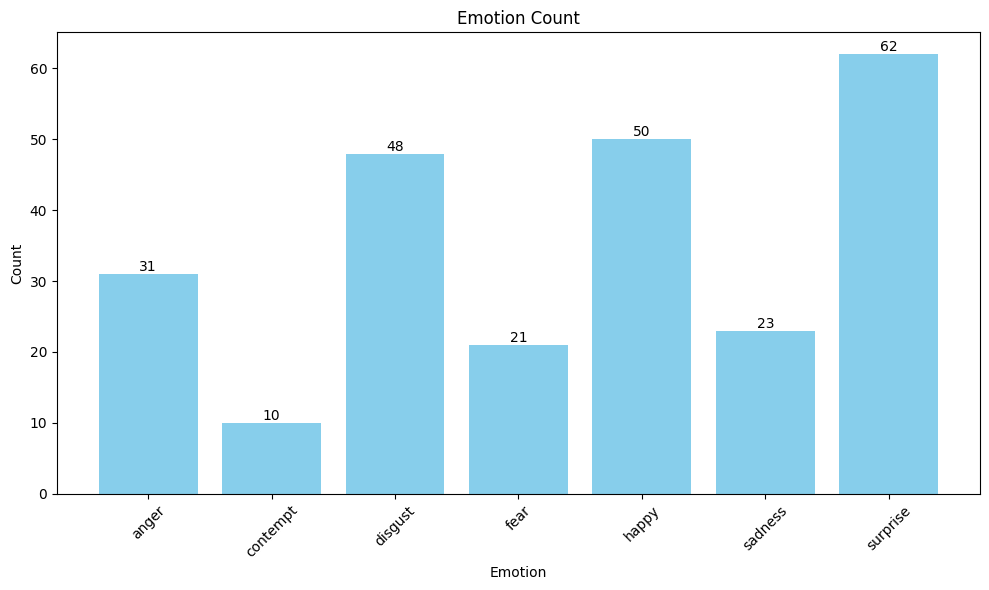

In [8]:
# Just to have a better view of our train data!
plot_count(train_data, train_labels)

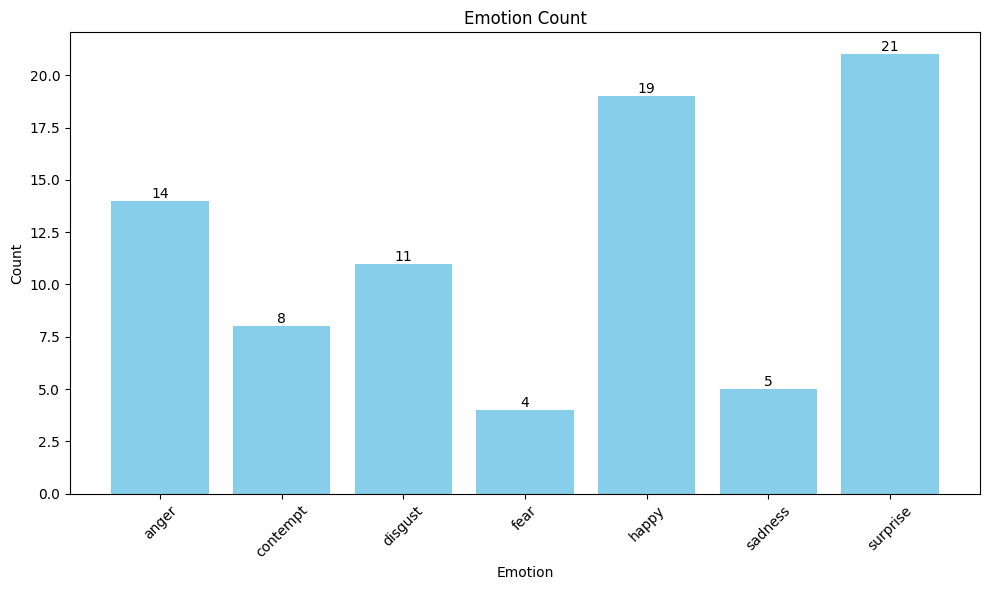

In [9]:
# Just to have a better view of our test_data!
plot_count(test_data, test_labels)

In [10]:
# Here, we'll use different approach to unbalanced data. Because disgust is much smaller class than the others, 
#we'll make more models, and use voting when we testing

In [11]:
train_data, train_labels = add_mirrored_images_upto(train_data, train_labels, upto=4*11, include=["contempt", "disgust", "fear", "sadness"])

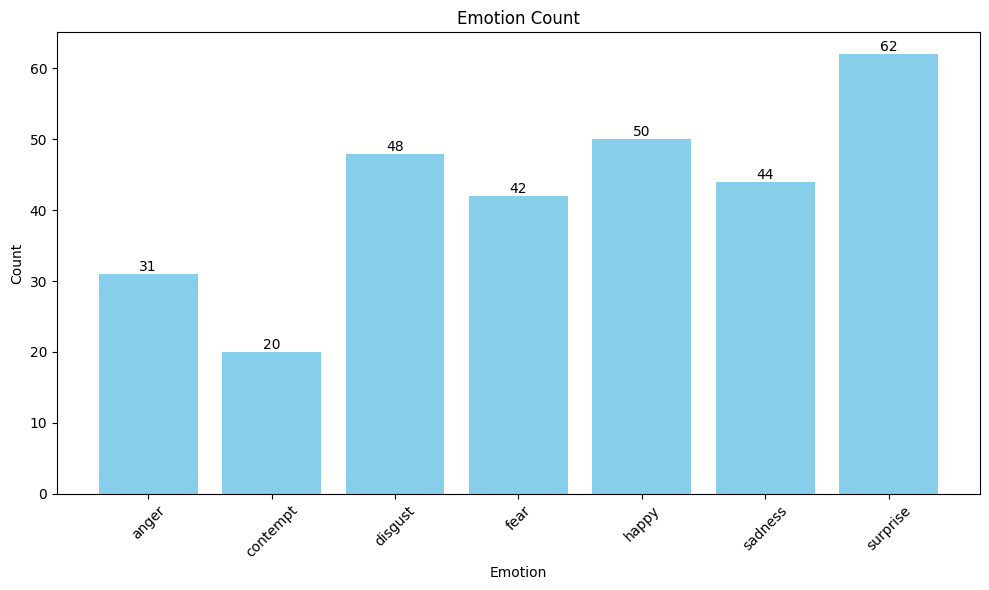

In [12]:
plot_count(train_data, train_labels)

In [13]:
seed = 12
#train_data, train_labels = random_delete_upto_2(train_data, train_labels, "anger", 20*11, seed)
#train_data, train_labels = random_delete_upto_2(train_data, train_labels, "contempt", 20*11, seed)
#train_data, train_labels = random_delete_upto_2(train_data, train_labels, "fear", 20*11, seed)

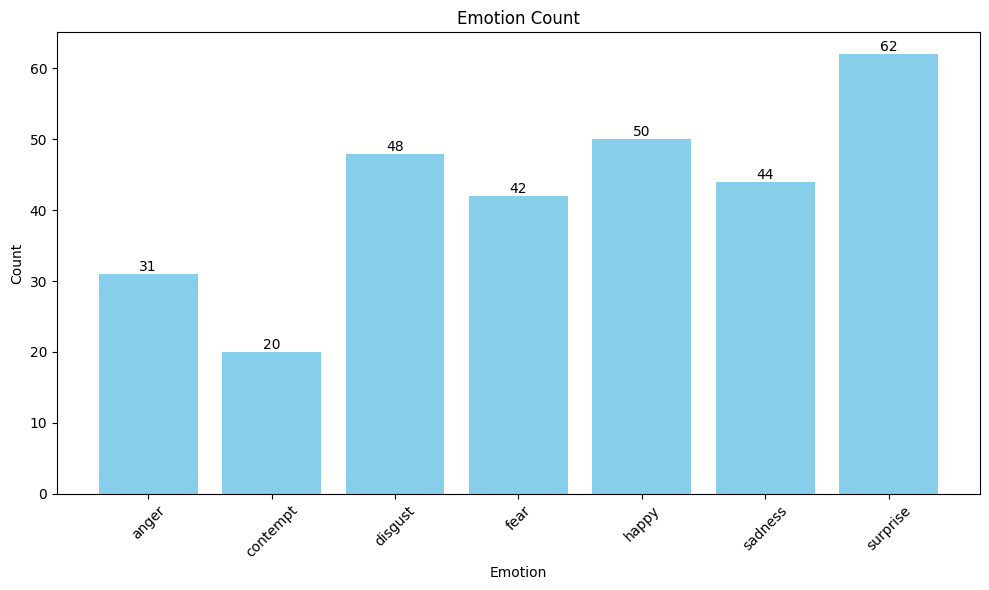

In [13]:
plot_count(train_data, train_labels)

In [14]:
# Just checking whether we work with corect labels!
set_labels=set()
set_test_labels=set()
for label in train_labels:
    #print(label, end='')
    if label not in set_labels:
        set_labels.add(label)
        print(label, end=' ')
print('\n------------------------------------------') 
for label in test_labels:
    if label not in set_test_labels:
        set_test_labels.add(label)
        print(label, end=' ')

sadness surprise disgust anger happy fear contempt 
------------------------------------------
anger surprise happy disgust contempt sadness fear 

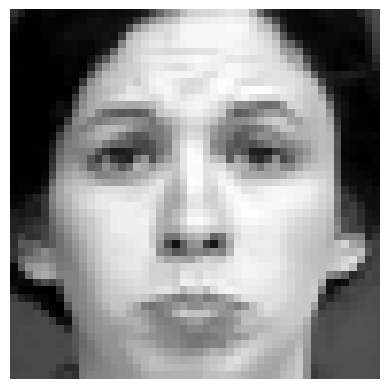

sadness


In [15]:
# Just to see with what kind of images we are dealing with!
plot_image(train_data[0], train_labels[0])

In [15]:
# Checking the shape of train data and setting global variables which we will use later!

print(train_data[0].shape)
print(train_labels[0])

ROWS=48
COLS=48
NUM_OF_CHANNELS=1
NUM_OF_CLASSES=7
K.image_data_format()

(48, 48)
sadness


'channels_last'

In [16]:
# Changing the dimensions of our data in order to fit in our neural nets!

#train_data.shape
train_data=np.array(train_data)
test_data=np.array(test_data)
train_data = train_data.reshape(train_data.shape[0], ROWS, COLS, 1)
test_data = test_data.reshape(test_data.shape[0], ROWS, COLS, 1)
input_shape = (ROWS, COLS, 1)

In [17]:
# Checking the size of our data again!
print(train_data.shape)
print(test_data.shape)

(297, 48, 48, 1)
(82, 48, 48, 1)


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [21]:
alexnet_model = Sequential([
    Conv2D(96, kernel_size=(11,11), strides=(1,1), padding='same', activation='relu', input_shape=(ROWS, COLS, NUM_OF_CHANNELS)),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dense(NUM_OF_CLASSES, activation='softmax')
    #Dense(1, activation='softmax')
])

In [22]:
# Just to see again the content of our network, but better represented!
alexnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 96)        11712     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 384)      

In [23]:
# Checking the size of our data again!
print(test_data.shape)
print(test_labels.shape)
print('-------------------')
print(train_data.shape)
print(train_labels.shape)

(82, 48, 48, 1)
(82,)
-------------------
(297, 48, 48, 1)
(297,)


In [24]:
# Decreasing the scale of our train data! It will now be within [0, 1] interval!
train_data=train_data.astype('float32')
train_data/=255

In [25]:
# Decreasing the scale of our test data! It will now be within [0, 1] interval!
test_data=test_data.astype('float32')
test_data/=255

In [26]:
# Here we are going to convert our train labels into float numbers!

EPOCHS = 20
BATCH_SIZE = 128

train_data=np.array(train_data)
train_labels=np.array(train_labels)
train_labels_new=[]
for label in train_labels:
    if label=='anger':
        train_labels_new.append(0)
    if label=='contempt':
        train_labels_new.append(1)
    if label=='disgust':
        train_labels_new.append(2)
    if label=='fear':
        train_labels_new.append(3)
    if label=='happy':
        train_labels_new.append(4)
    if label=='sadness':
        train_labels_new.append(5)
    if label=='surprise':
        train_labels_new.append(6)
train_labels_new=np.array(train_labels_new)
print(train_labels_new.shape)
train_labels=train_labels_new

(297,)


In [27]:
# Here we are going to convert our test labels into float numbers!

test_data=np.array(test_data)
test_labels=np.array(test_labels)
test_labels_new=[]
for label in test_labels:
    if label=='anger':
        test_labels_new.append(0)
    if label=='contempt':
        test_labels_new.append(1)
    if label=='disgust':
        test_labels_new.append(2)
    if label=='fear':
        test_labels_new.append(3)
    if label=='happy':
        test_labels_new.append(4)
    if label=='sadness':
        test_labels_new.append(5)
    if label=='surprise':
        test_labels_new.append(6)
test_labels_new=np.array(test_labels_new)
print(test_labels_new.shape)
test_labels=test_labels_new

(82,)


In [28]:
# Checking whether everything was okay with converting train and test labels!
print(train_labels[0])
print(train_data.shape)
set_labels=set()
for label in train_labels:
    if label not in set_labels:
        set_labels.add(label)
        print(label, end=' ')

5
(297, 48, 48, 1)
5 6 2 0 4 3 1 

In [29]:
# Converting train and test labels from float values to coresponding vectors!
number_of_classes = 7

train_labels=utils.to_categorical(train_labels, number_of_classes)
test_labels=utils.to_categorical(test_labels, number_of_classes)

In [30]:
# This is how they look now!
print(train_labels[0])
print(test_labels[0])

[0. 0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0. 0.]


In [31]:
# Compiling alexnet neural network!
alexnet_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [117]:
# Now, we can let our model to train!
#history = alexnet_model.fit(train_data, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=1)

In [ ]:
# After training our model, we will show the values of loss function and accuracy function
# on training and validation set throught epochs!
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Loss function on training and validation set')
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy on training and validation set')
plt.plot(history.epoch, history.history['accuracy'], label='train')
plt.plot(history.epoch, history.history['val_accuracy'], label='val')
plt.legend(loc='best')

# In case you would like to save a diagram picture, uncomment a line bellow!
plt.savefig('the_first_results.png')

plt.show()

In [ ]:
# Here we will evaluate the model of our interest on the test data!

model=alexnet_model
score=model.evaluate(test_data, test_labels)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Here we will evaluate the model of our interest on the train data!

score=model.evaluate(train_data, train_labels)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Predicted values of model for the test data!
# We will use different notation here, just to make our code more readable!

X_test=test_data
y_test=test_labels
y_predicted = model.predict(X_test)
y_predicted_classes = np.argmax(y_predicted, axis = 1)

In [ ]:
# Just checking shapes!
print(y_predicted_classes.shape)
y_test_classes = np.argmax(y_test, axis = 1)
print(y_test_classes.shape)

In [ ]:
# Creating and printing the confusion matrix of our model!

confusion_matrix= confusion_matrix(y_test_classes, y_predicted_classes)
print(confusion_matrix)

In [ ]:
#Creating and displaying classification report about our model!

report = classification_report(y_test_classes, y_predicted_classes)
print(report)

# We will now try to test different model!

In [32]:
# Here you can see a way smaller and simplier model than alexnet model. It will have way better results with it! 
model = Sequential([
    Input(shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(number_of_classes, activation='softmax')
])

In [33]:
# Presenting the summary of our new model!
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 36864)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               4718720   
                                                      

In [34]:
# Compiling our model!
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [35]:
# Setting global variables and moving to different/simplier annotation!
batch_size = 128
epochs = 20

X_train=train_data
y_train=train_labels
X_test=test_data
y_test=test_labels

In [39]:
# We will now let our model to train!
# This cell has been executed a couple of times!
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/20
2/2 [==============================] - 1s 298ms/step - loss: 0.0824 - accuracy: 0.9831 - val_loss: 0.5459 - val_accuracy: 0.8000
Epoch 2/20
2/2 [==============================] - 1s 355ms/step - loss: 0.0730 - accuracy: 0.9873 - val_loss: 0.5541 - val_accuracy: 0.8000
Epoch 3/20
2/2 [==============================] - 1s 380ms/step - loss: 0.0882 - accuracy: 0.9747 - val_loss: 0.5552 - val_accuracy: 0.7833
Epoch 4/20
2/2 [==============================] - 0s 238ms/step - loss: 0.0802 - accuracy: 0.9789 - val_loss: 0.5341 - val_accuracy: 0.8167
Epoch 5/20
2/2 [==============================] - 0s 217ms/step - loss: 0.0779 - accuracy: 0.9831 - val_loss: 0.5453 - val_accuracy: 0.8333
Epoch 6/20
2/2 [==============================] - 1s 351ms/step - loss: 0.0686 - accuracy: 0.9747 - val_loss: 0.5399 - val_accuracy: 0.7833
Epoch 7/20
2/2 [==============================] - 1s 242ms/step - loss: 0.0536 - accuracy: 0.9831 - val_loss: 0.4876 - val_accuracy: 0.8167
Epoch 8/20
2/2 [====

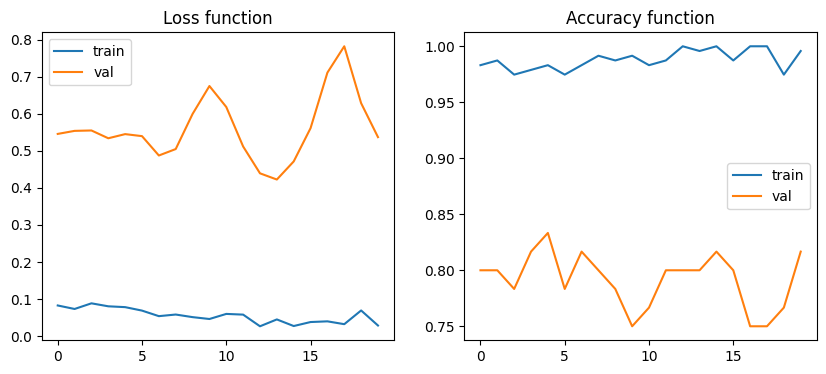

In [47]:
# After training our model, we will show the values of loss function and accuracy function
# on training and validation set throught epochs!

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss function')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy function')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

In [48]:
# Here we will evaluate our model on test data!

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7040451169013977
Test accuracy: 0.8658536672592163


In [49]:
from sklearn.metrics import confusion_matrix, classification_report

In [50]:
# Using method predict in our to display confusion matrix and calssification report later!
y_predicted = model.predict(X_test)
y_predicted_classes = np.argmax(y_predicted, axis = 1) 

3/3 [==============================] - 0s 14ms/step


In [51]:
# Just checking something!
print(y_predicted[0])
print(y_test[0])
print(np.argmax(y_predicted[0]))
print(np.argmax(y_test[0]))

[9.9921048e-01 4.3709508e-05 2.8796281e-05 3.4559558e-05 1.4870241e-06
 6.1189971e-04 6.9117566e-05]
[1. 0. 0. 0. 0. 0. 0.]
0
0


In [52]:
# Just checking the shapes again!
print(y_predicted_classes.shape)
y_test_classes = np.argmax(y_test, axis = 1) 
print(y_test_classes.shape)

(82,)
(82,)


In [53]:
# Creating and printing the confusion matrix of our model!

confusion_matrix= confusion_matrix(y_test_classes, y_predicted_classes)
print(confusion_matrix)

[[ 9  0  1  0  0  4  0]
 [ 0  6  0  0  0  0  2]
 [ 0  0 11  0  0  0  0]
 [ 0  1  0  3  0  0  0]
 [ 0  0  1  0 18  0  0]
 [ 0  0  0  0  0  3  2]
 [ 0  0  0  0  0  0 21]]


In [54]:
#Creating and displaying classification report about our model!

report = classification_report(y_test_classes, y_predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        14
           1       0.86      0.75      0.80         8
           2       0.85      1.00      0.92        11
           3       1.00      0.75      0.86         4
           4       1.00      0.95      0.97        19
           5       0.43      0.60      0.50         5
           6       0.84      1.00      0.91        21

    accuracy                           0.87        82
   macro avg       0.85      0.81      0.82        82
weighted avg       0.89      0.87      0.87        82



In [55]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.autograd import Variable

#import transforms as transforms
from skimage import io
from skimage.transform import resize
#from models import *

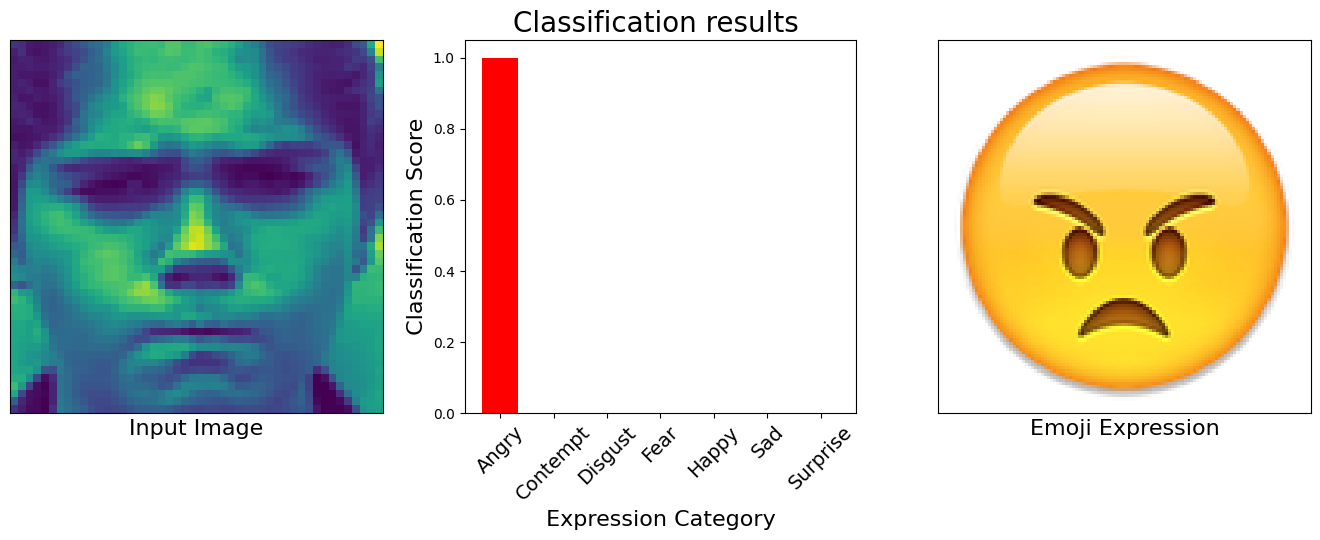

The Expression is Angry!


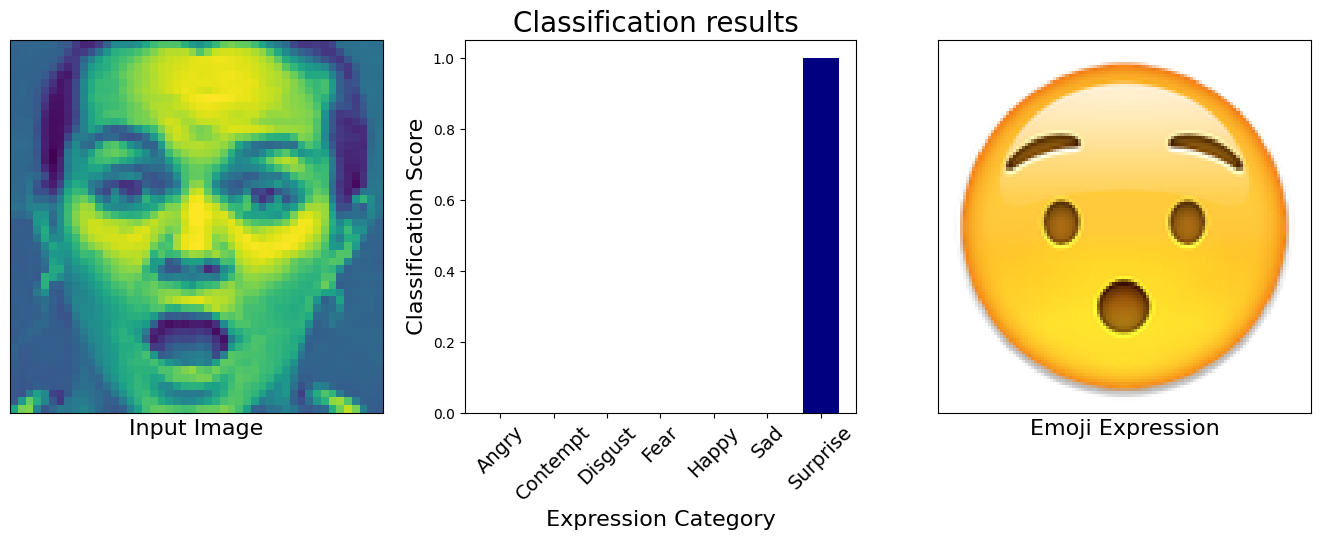

The Expression is Surprise!


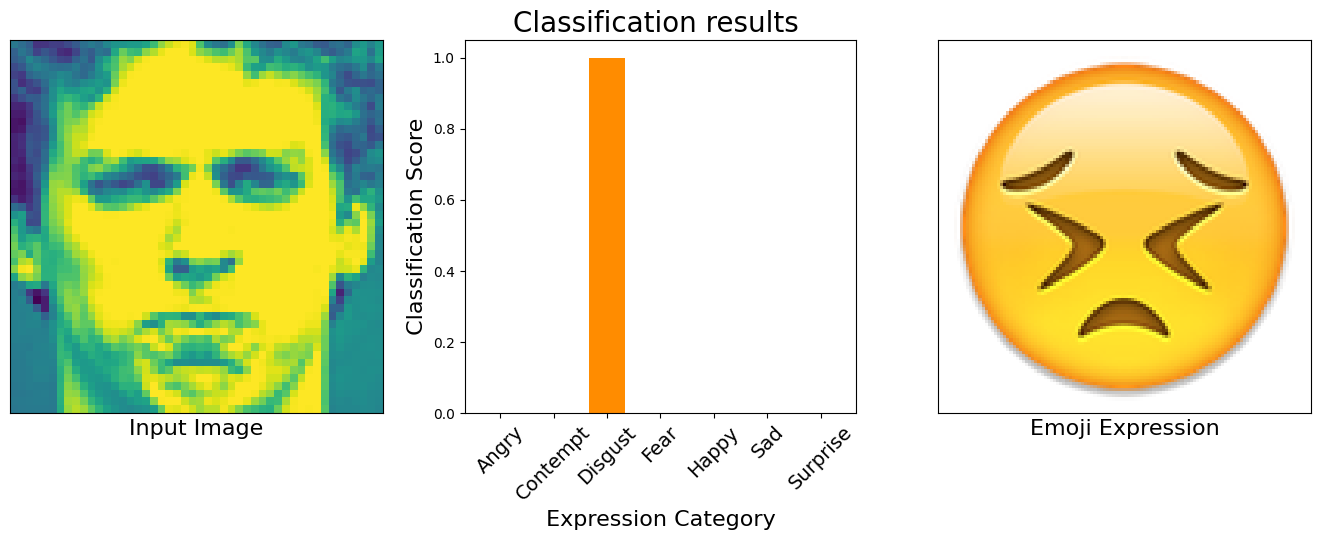

The Expression is Disgust!


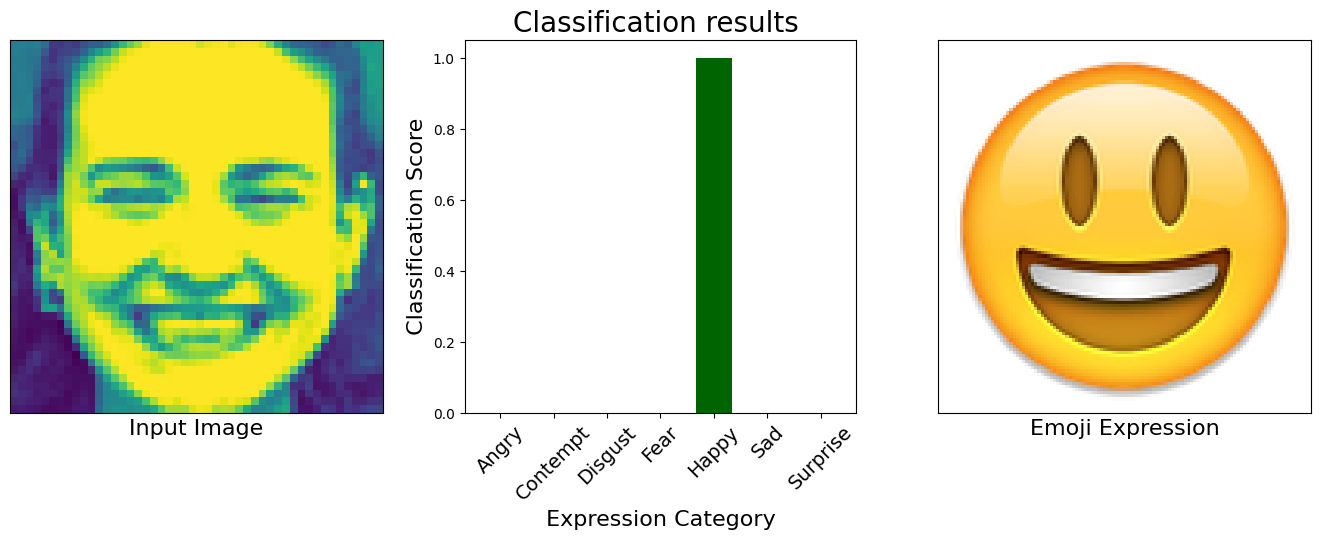

The Expression is Happy!


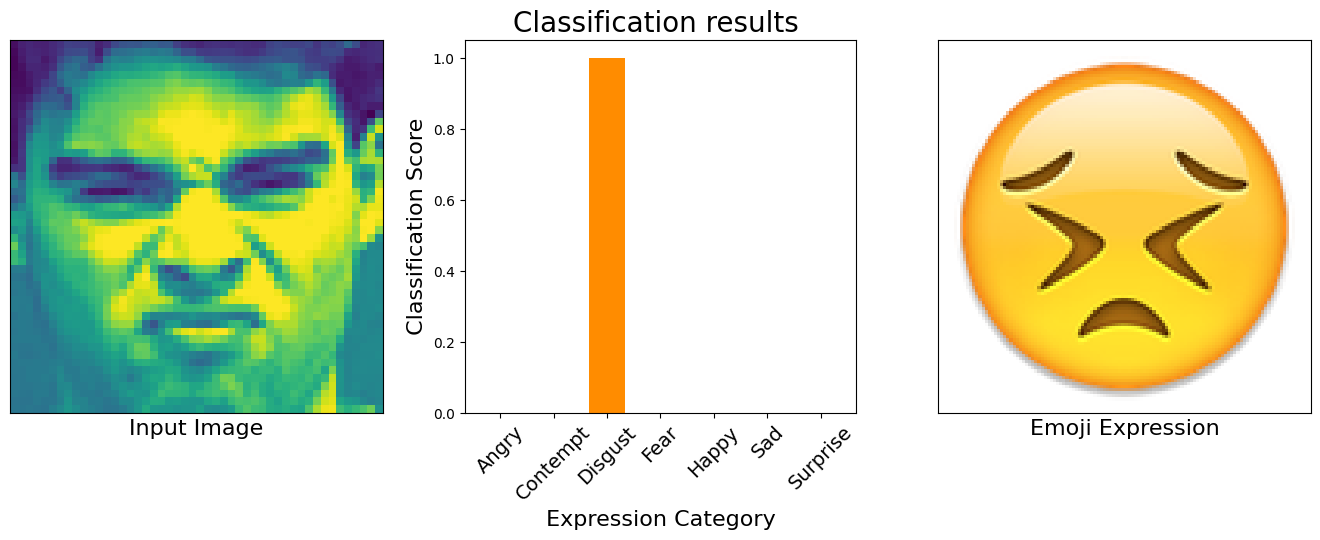

The Expression is Disgust!


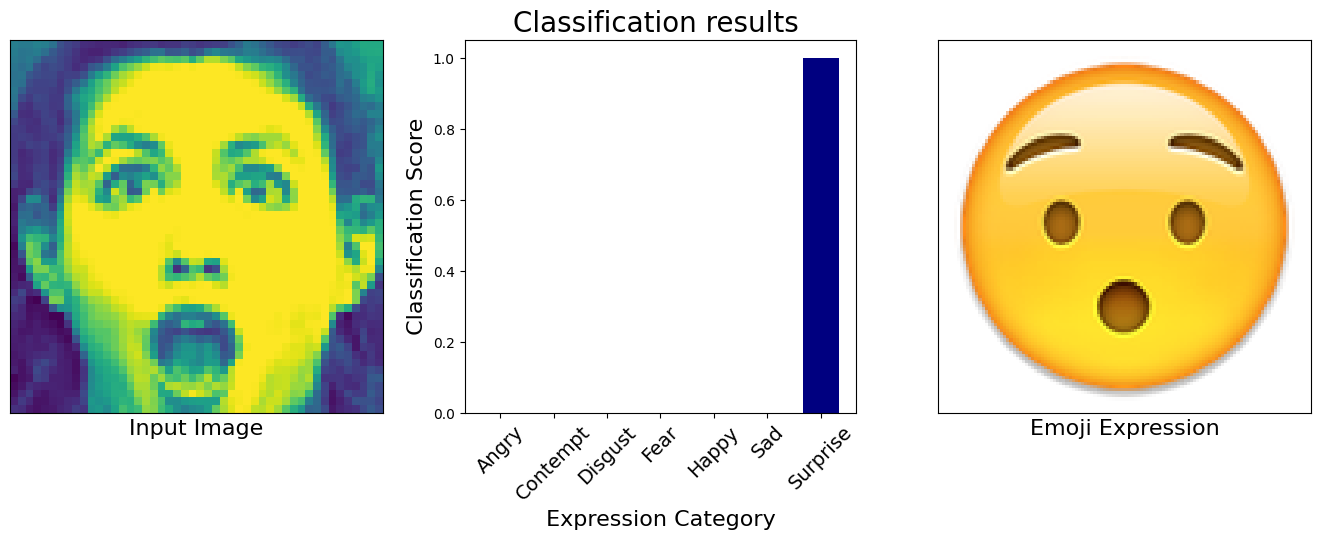

The Expression is Surprise!


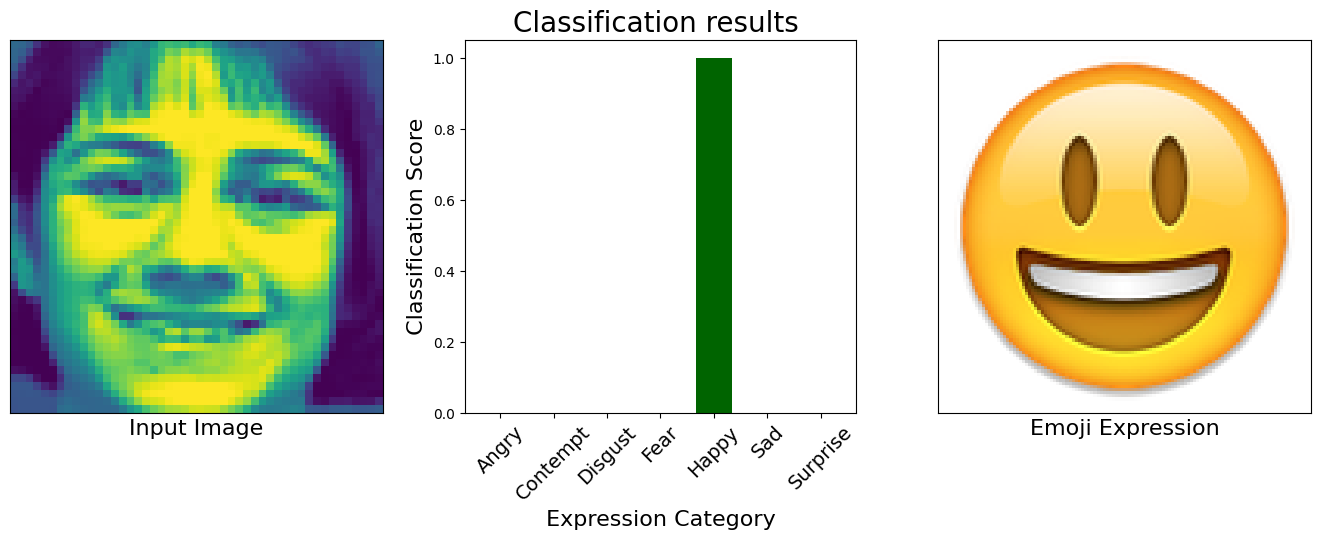

The Expression is Happy!


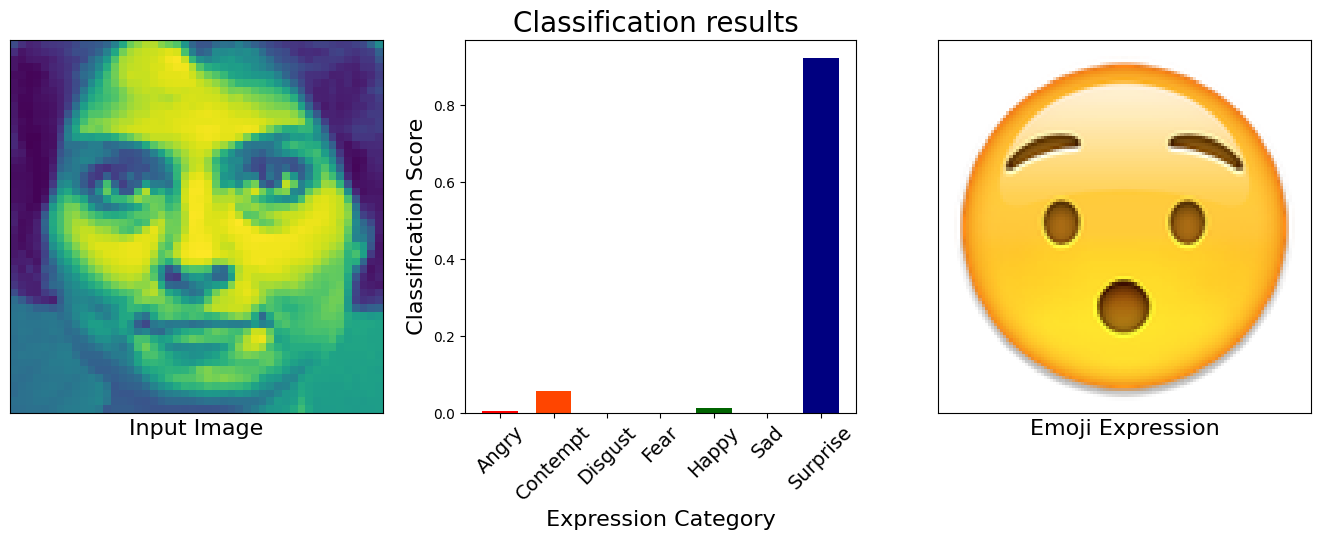

The Expression is Surprise!


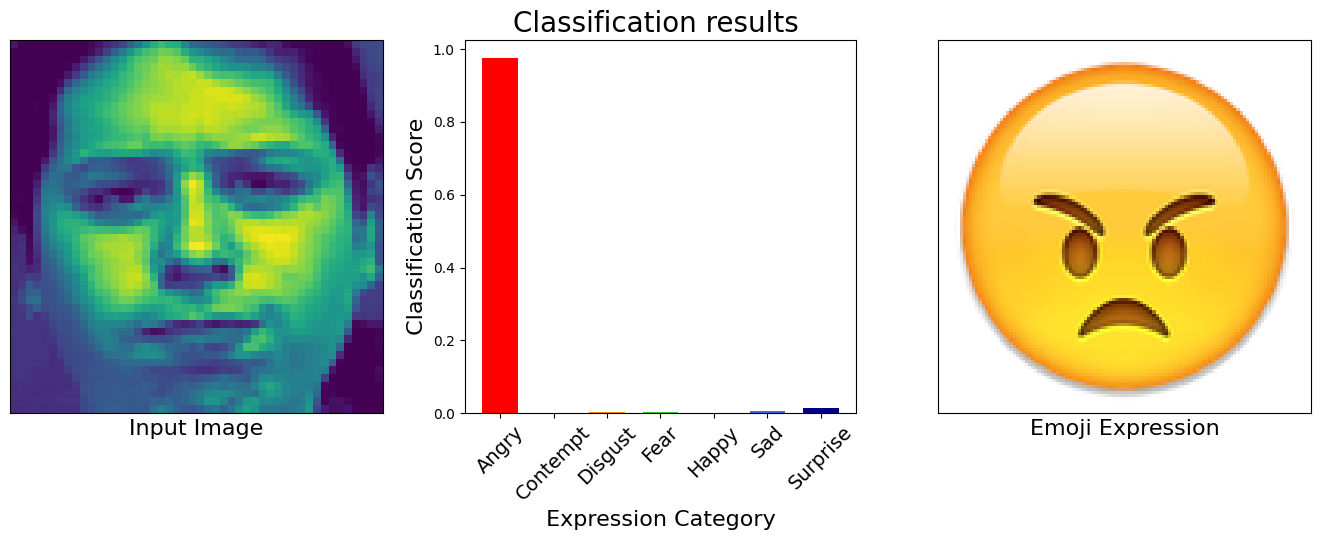

The Expression is Angry!


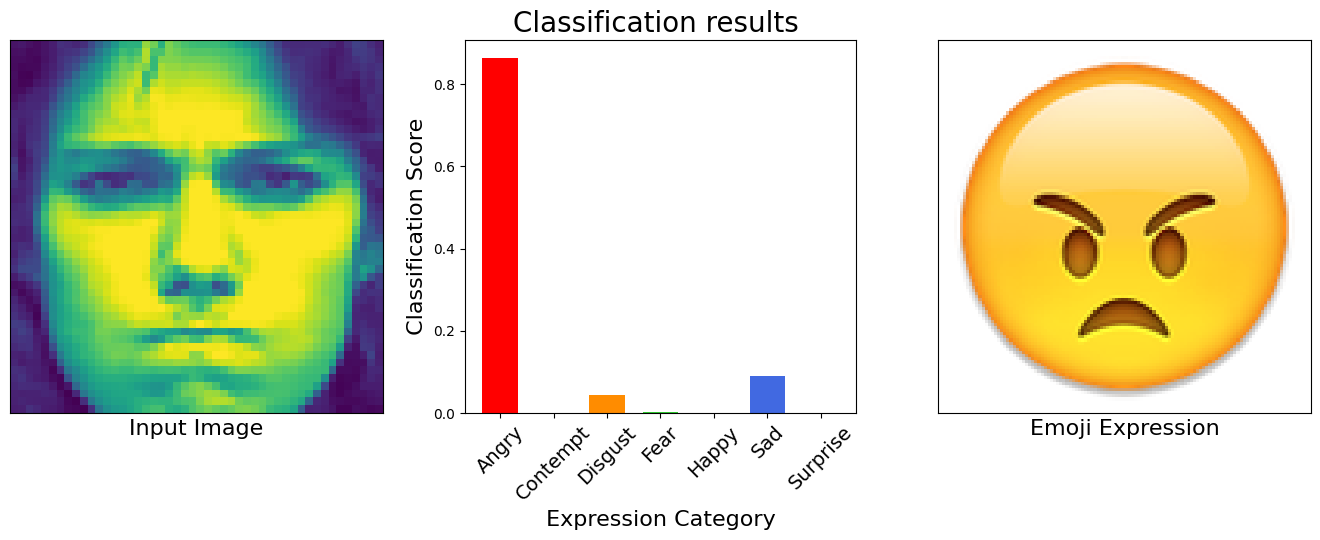

The Expression is Angry!


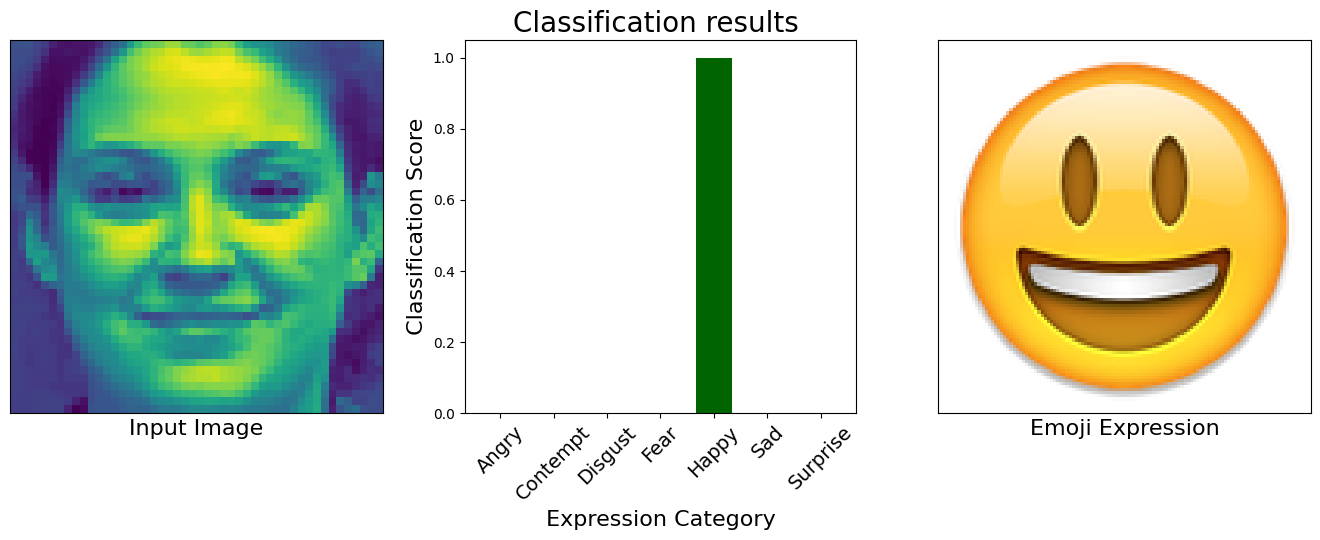

The Expression is Happy!


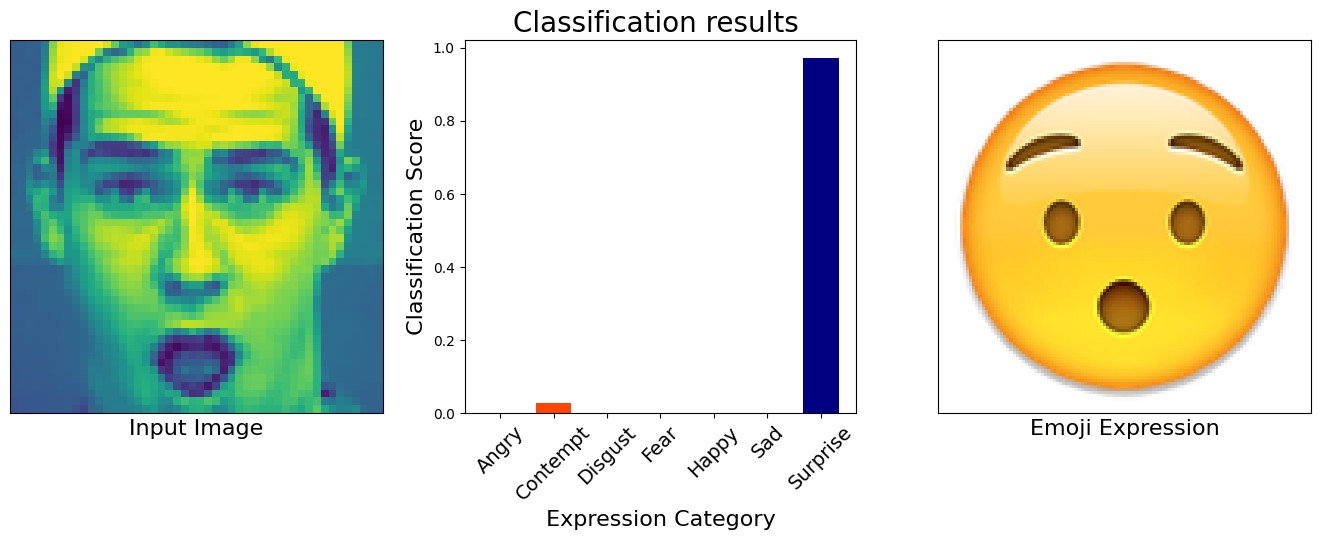

The Expression is Surprise!


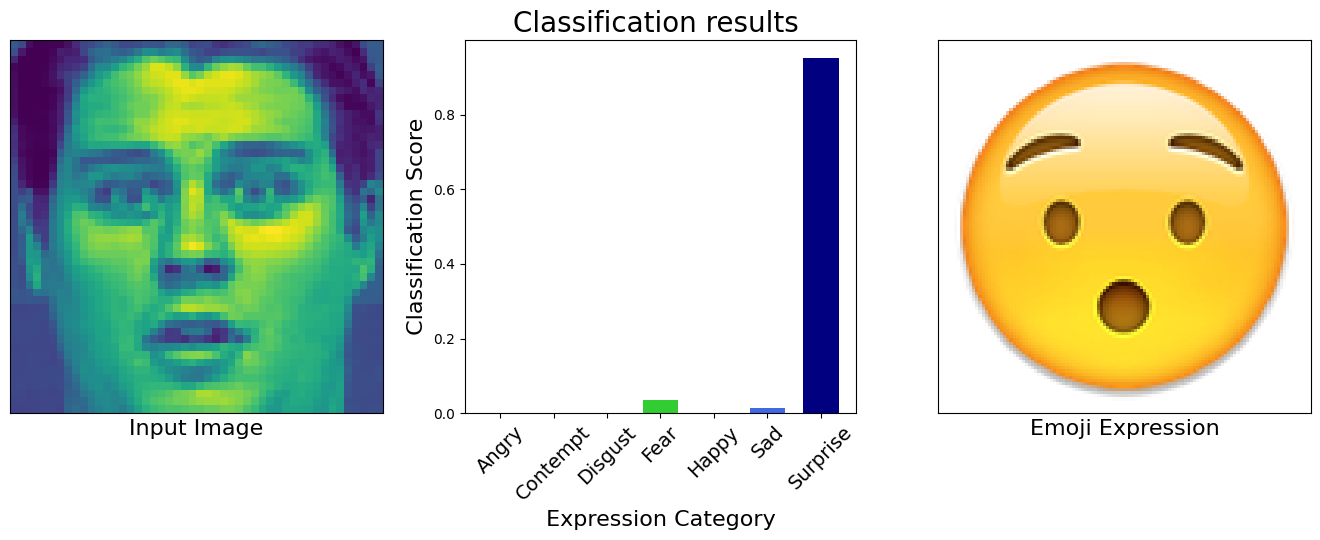

The Expression is Surprise!


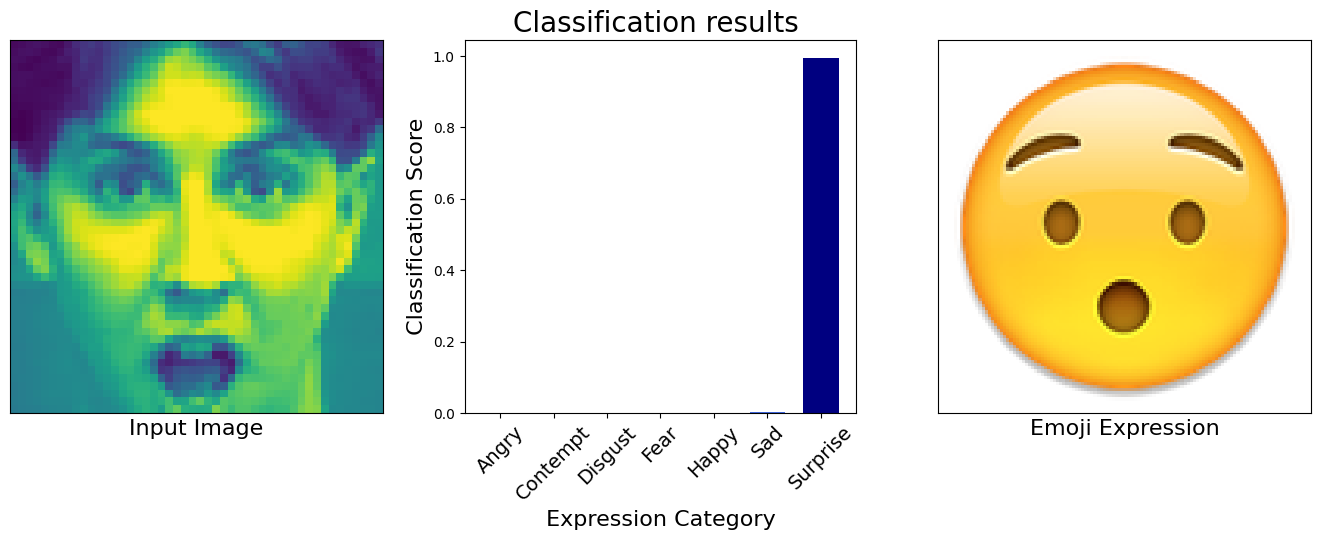

The Expression is Surprise!


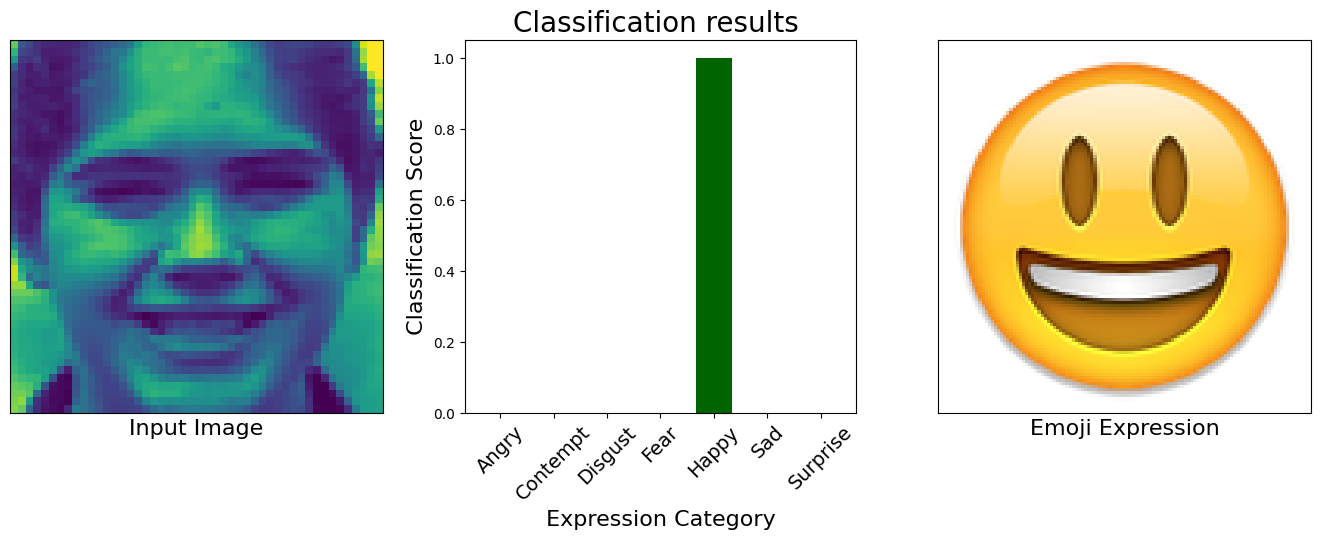

The Expression is Happy!


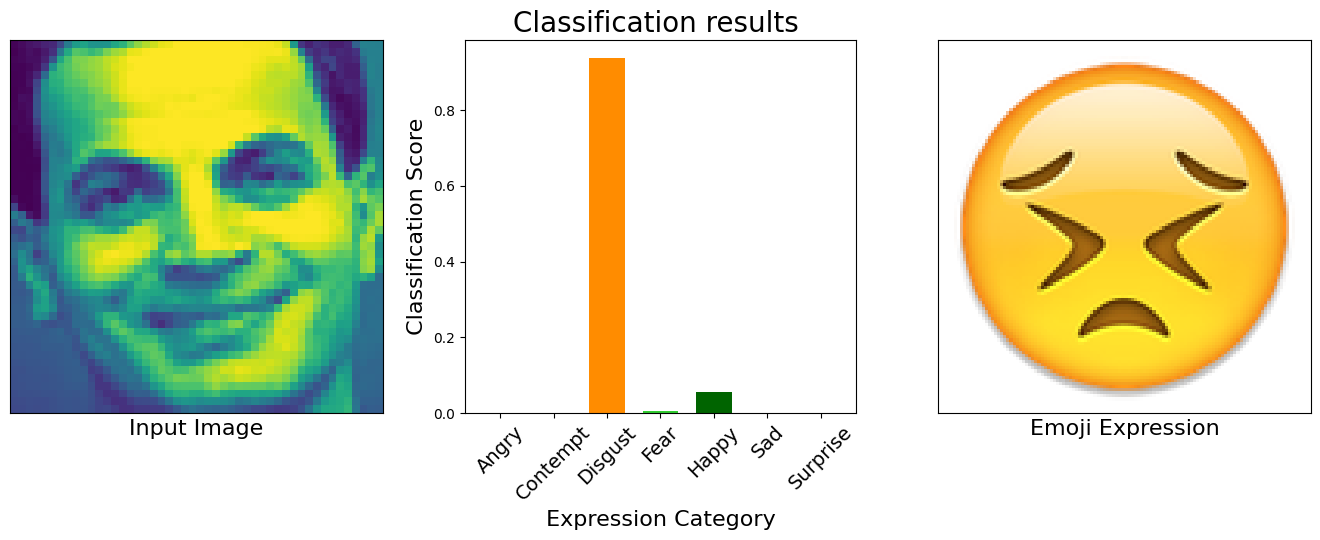

The Expression is Disgust!


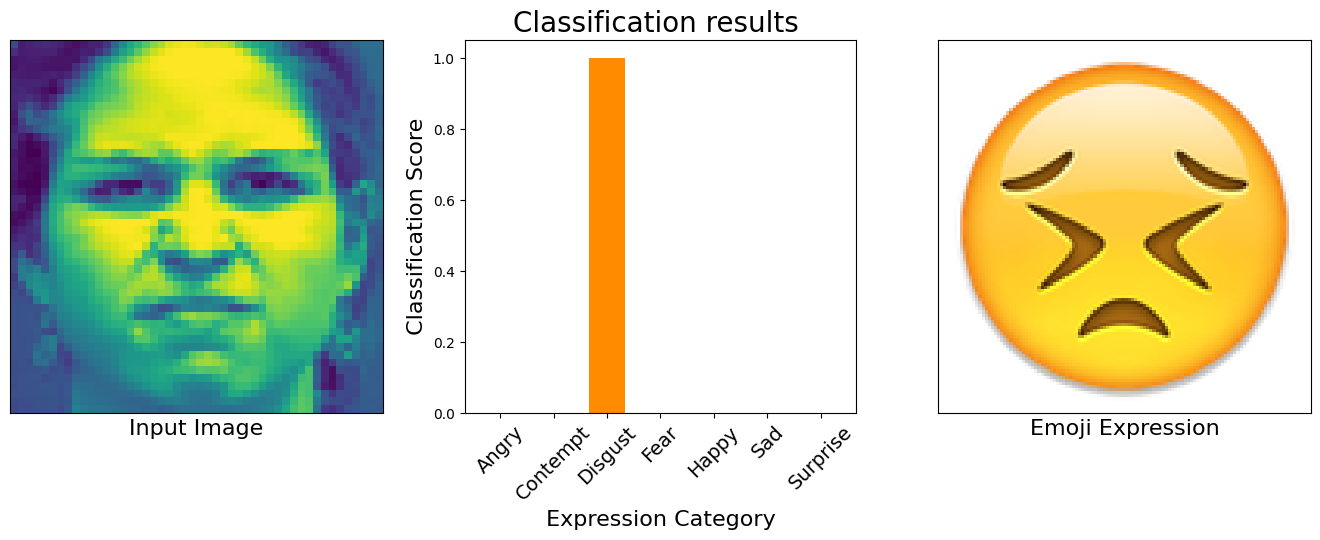

The Expression is Disgust!


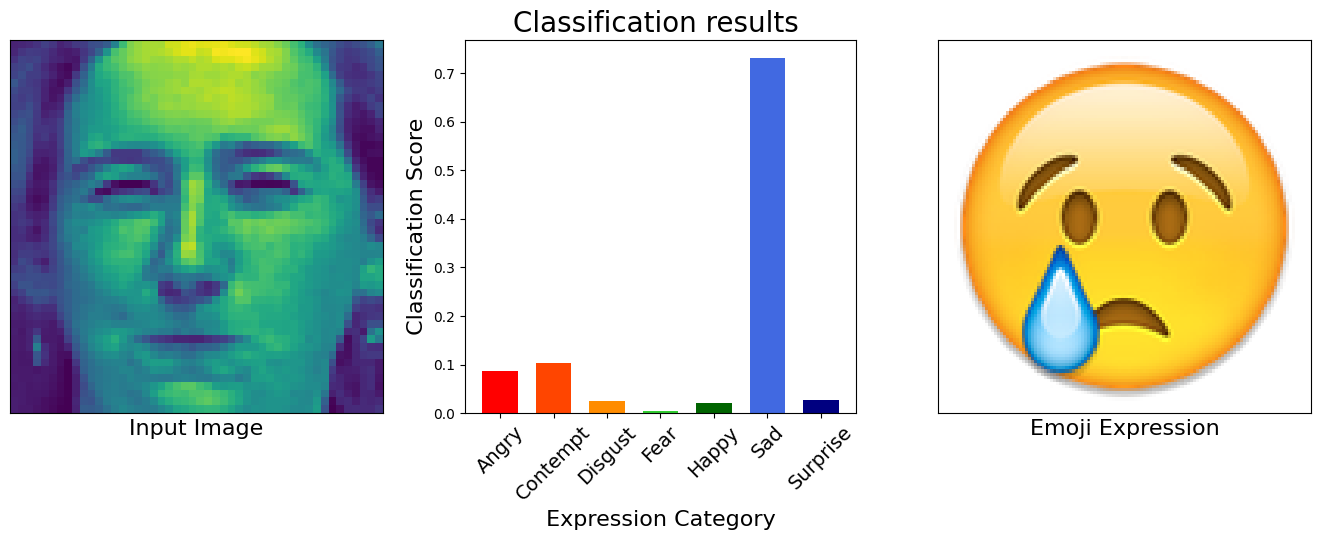

The Expression is Sad!


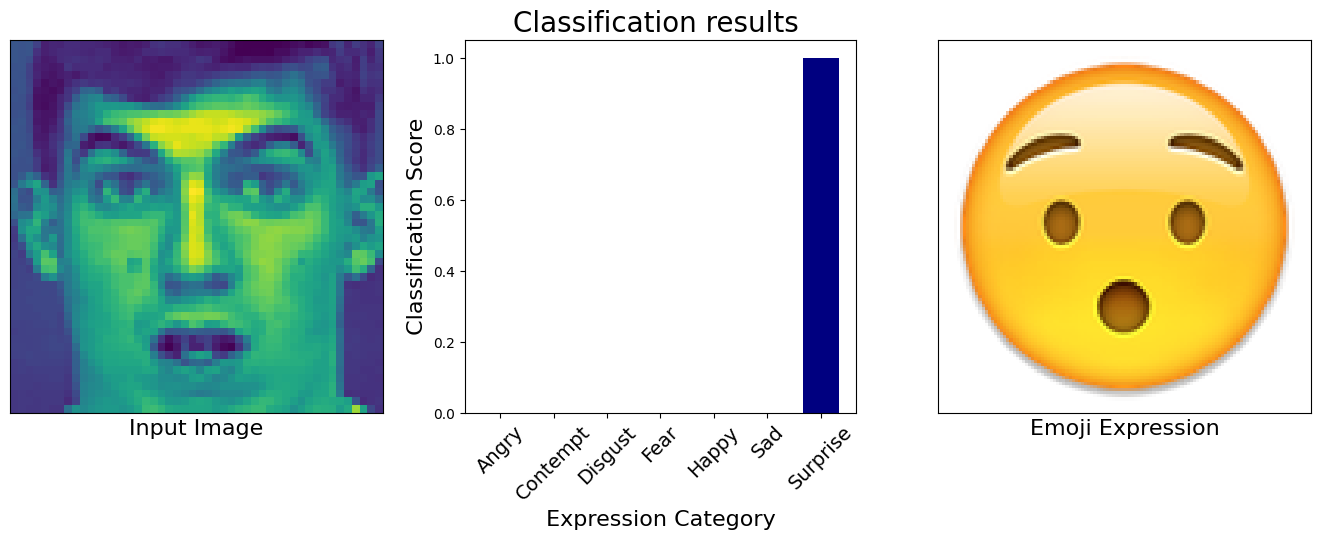

The Expression is Surprise!


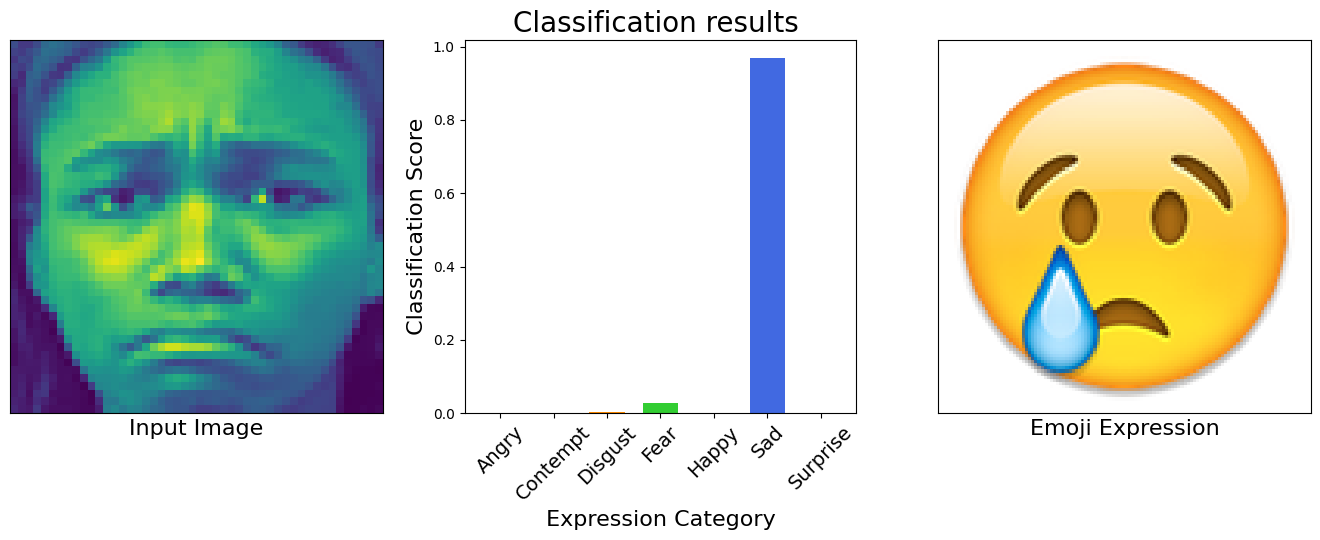

The Expression is Sad!


In [56]:
# Representing the results of our model hopefully in a more funny way!

class_names = ['Angry', 'Contempt', 'Disgust', 'Fear', 'Happy' ,'Sad', 'Surprise']


for j in range(20):
    plt.rcParams['figure.figsize'] = (13.5,5.5)
    axes=plt.subplot(1, 3, 1)
    #plt.imshow(raw_img)
    plt.imshow(X_test[j])
    plt.xlabel('Input Image', fontsize=16)
    axes.set_xticks([])
    axes.set_yticks([])
    plt.tight_layout()


    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.95, top=0.9, hspace=0.02, wspace=0.3)

    plt.subplot(1, 3, 2)
    ind = 0.1+0.6*np.arange(len(class_names))    # the x locations for the groups
    width = 0.4       # the width of the bars: can also be len(x) sequence
    color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']
    for i in range(len(class_names)):
        plt.bar(ind[i], y_predicted[j][i], width, color=color_list[i])
    plt.title("Classification results ",fontsize=20)
    plt.xlabel(" Expression Category ",fontsize=16)
    plt.ylabel(" Classification Score ",fontsize=16)
    plt.xticks(ind, class_names, rotation=45, fontsize=14)

    axes=plt.subplot(1, 3, 3)
    emojis_img = io.imread('datasets/images/emojis/%s.png' % str(class_names[int(np.argmax(y_predicted[j]))]))
    plt.imshow(emojis_img)
    plt.xlabel('Emoji Expression', fontsize=16)
    axes.set_xticks([])
    axes.set_yticks([])
    plt.tight_layout()
    # show emojis

    plt.show()
    #plt.savefig(os.path.join('images/results/l.png'))
    plt.close()

    print("The Expression is %s!" %str(class_names[int(np.argmax(y_predicted[j]))]))